In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
import plotly.io as pio
pio.renderers.default = "jupyterlab+png"

In [3]:
points = pd.read_csv("schools_and_nearst_bus_stops.csv")
points.head()

,latitude,longitude,name,type
0,-12.973049,-38.454253,29179670,School
1,-12.954214,-38.437683,29181283,School
2,-12.965289,-38.464399,29181291,School
3,-12.971366,-38.461385,29185262,School
4,-12.973354,-38.454936,29194288,School


In [4]:
boarding = pd.read_parquet("03_boarding_19-04-2024_19-04-2024.parquet")
boarding.head()

,registers,start_trip,end_trip,tolerance,integration,cod_card,stop_time,register_time,service_code,route_short_name,...,classification,motive,trip,set_nb,route_short_name_nb,vehicle_nb,stop_id_nb,diff_nb,motive_pe,target_boarding
0,1,2024-04-19 13:33:37,2024-04-19 13:33:37,NaT,False,2310031000647,2024-04-19 13:33:37,2024-04-19 13:33:37,None,MT02,...,regular,single_trip,single_trip,None,None,None,None,NaN,single trip,irregular
1,1,2024-04-19 17:03:01,2024-04-19 17:03:01,NaT,False,2310031008892,2024-04-19 17:03:01,2024-04-19 17:03:01,None,MT02,...,regular,single_trip,single_trip,None,None,None,None,NaN,single trip,irregular
2,2,2024-04-19 08:04:24,2024-04-19 08:04:24,NaT,False,2310031012641,2024-04-19 08:04:24,2024-04-19 08:04:24,None,MT02,...,regular,regular,firt_trip,metro,MT02,59825,RDV,0.0,regular,regular
3,2,2024-04-19 18:19:36,2024-04-19 18:19:36,NaT,False,2310031012641,2024-04-19 18:19:36,2024-04-19 18:19:36,None,MT02,...,regular,regular,last_trip,metro,MT02,58660,RTI,0.0,regular,regular
4,2,2024-04-19 05:55:44,2024-04-19 05:55:44,NaT,False,2310031020593,2024-04-19 05:55:44,2024-04-19 05:55:44,None,MT02,...,regular,regular,firt_trip,metro,MT02,58801,IMB,0.0,regular,regular


In [5]:
# Get Travels to a Bus Stop Close to a School
filtered_df = points[points["type"] == "Bus Stop"]
boarding = boarding[boarding["stop_id"].isin(filtered_df["name"])]
boarding.head()

,registers,start_trip,end_trip,tolerance,integration,cod_card,stop_time,register_time,service_code,route_short_name,...,classification,motive,trip,set_nb,route_short_name_nb,vehicle_nb,stop_id_nb,diff_nb,motive_pe,target_boarding
10604,1,2024-04-19 11:20:09,2024-04-19 12:22:54,NaT,False,2300033479396,2024-04-19 11:58:22,2024-04-19 11:59:26,69127,142002,...,regular,single_trip,single_trip,None,None,None,None,NaN,single trip,irregular
10606,1,2024-04-19 09:24:40,2024-04-19 11:11:45,NaT,False,2300033506243,2024-04-19 10:19:24,2024-04-19 10:20:25,45546,0310,...,regular,single_trip,single_trip,None,None,None,None,NaN,single trip,irregular
10617,1,2024-04-19 11:09:25,2024-04-19 13:08:59,NaT,False,2300033517598,2024-04-19 12:12:26,2024-04-19 12:12:27,45546,0310,...,regular,single_trip,single_trip,None,None,None,None,NaN,single trip,irregular
10631,2,2024-04-19 15:29:19,2024-04-19 15:39:32,NaT,False,2300033573026,2024-04-19 15:35:10,2024-04-19 15:35:15,53685,1133,...,regular,regular,firt_trip,ottrans,1133,21345,45833578,0.8,regular,regular
10644,5,2024-04-19 17:02:18,2024-04-19 18:59:10,NaT,False,2300033981230,2024-04-19 17:52:54,2024-04-19 17:55:44,45546,0310,...,regular,regular,last_trip,ottrans,0310,20007,44782849,17.4,regular,regular


In [6]:
# Get The Number of Passegeners in Each bus stop
all_passengers = boarding.groupby('stop_id').size().reset_index(name='count')
all_passengers = all_passengers[all_passengers['stop_id'].str.len() > 4]
all_passengers.head()

,stop_id,count
0,100722777,1122
1,101214305,149
2,104226128,64
3,104226131,55
4,106367556,41


In [7]:
# Get The Number os Students in Each Bus stop
students = boarding[boarding['cod_card'].str.startswith('365')].reset_index(drop=True)
students = students[students['stop_id'].str.len() > 4]
students = students.groupby('stop_id').size().reset_index(name='students_count')
students.head()

,stop_id,students_count
0,100722777,107
1,101214305,16
2,104226128,11
3,104226131,4
4,106367556,1


In [8]:
# Merge the results in one Dataframe For plotting 
all_passengers = all_passengers.merge(students, on="stop_id", how="left")
all_passengers["students_count"].fillna(0,inplace=True)

all_passengers['students_count'] = all_passengers['students_count'].astype(int)
all_passengers = all_passengers.merge(points[["latitude","longitude","name"]], left_on = "stop_id",right_on="name",how="left")

all_passengers.drop("name",axis=1, inplace=True)
all_passengers.head()

/tmp/ipykernel_29031/1192188866.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,stop_id,count,students_count,latitude,longitude
0,100722777,1122,107,-12.899299,-38.407673
1,101214305,149,16,-12.870927,-38.433800
2,104226128,64,11,-12.922891,-38.490807
3,104226131,55,4,-12.924791,-38.485054
4,106367556,41,1,-12.925278,-38.413952


In [9]:
# Ajust Dataframe for Plotting
students_df = all_passengers[['stop_id', 'students_count', 'latitude', 'longitude']].copy()
students_df.rename(columns={'students_count': 'count'}, inplace=True)
students_df['type'] = 'Students'

all_passengers = all_passengers[['stop_id', 'count', 'latitude', 'longitude']].copy()
all_passengers['type'] = 'Total of passengers'


all_passengers = pd.concat([all_passengers, students_df], ignore_index=True)
all_passengers.head()

,stop_id,count,latitude,longitude,type
0,100722777,1122,-12.899299,-38.407673,Total of passengers
1,101214305,149,-12.870927,-38.433800,Total of passengers
2,104226128,64,-12.922891,-38.490807,Total of passengers
3,104226131,55,-12.924791,-38.485054,Total of passengers
4,106367556,41,-12.925278,-38.413952,Total of passengers


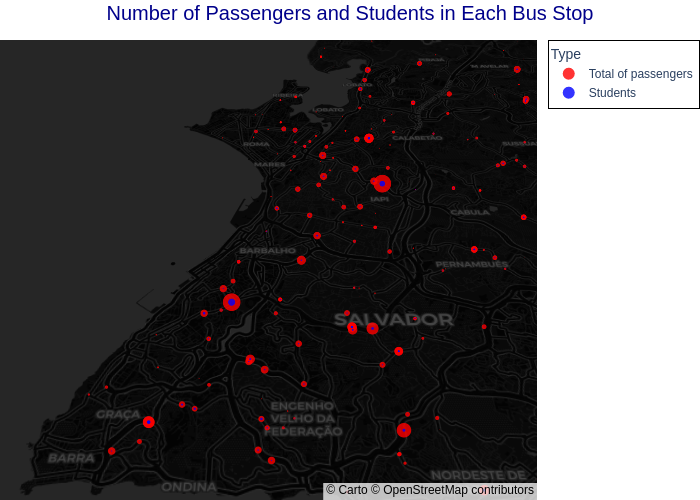

In [10]:
# Plot bubble map with enhanced styling
fig = px.scatter_mapbox(
    all_passengers,
    lat="latitude",
    lon="longitude",
    size="count",
    hover_name="stop_id",
    color="type",
    size_max=15,
    zoom=12,
    center={"lat": -12.9714, "lon": -38.5014},
    mapbox_style="carto-positron",
    title="Number of Passengers and Students in Each Bus Stop",
    opacity=0.7  # Set the opacity of the bubbles
)

# Update layout for better styling
fig.update_layout(
    title_font=dict(size=20, family='Arial, bold', color='darkblue'),
    title_x=0.5,  # Center the title
    margin={"r":0,"t":40,"l":0,"b":0},  # Adjust margins
    mapbox=dict(
        bearing=0,  # Set the map bearing
        pitch=45,  # Set the map pitch (tilt)
        style="carto-darkmatter",  # Use a dark map style
    ),
    showlegend=True,  # Display the legend
    legend=dict(
        title="Type",
        font=dict(size=12),
        bgcolor="rgba(255, 255, 255, 0.7)",
        bordercolor="Black",
        borderwidth=1,
    )
)

# Customize the marker appearance
fig.update_traces(marker=dict(
    sizemode='area',  # Size markers by area, not diameter
    opacity=0.8,
))

# Update colors: Blue for students and Red for total
fig.for_each_trace(
    lambda trace: trace.update(marker=dict(color='blue')) if trace.name == 'Students' else trace.update(marker=dict(color='red'))
)

# Save the plot as an image with the legend included
pio.write_image(fig, "Passengers_and_Students.png")

# Show the plot
fig.show()
